In [1]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Initialize BigQuery client
client = bigquery.Client()

/home/hankel/miniconda3/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/home/hankel/miniconda3/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


# RETENTION

In [2]:
query = """
WITH cohort AS (
    SELECT 
        user_pseudo_id,
        PARSE_DATE('%Y%m%d', event_date) as cohort_date
    FROM `royal-hexa-in-house.pixon_data_science.001_mock`
    WHERE event_name = 'first_open'
        AND event_date = '20250102'
),
daily_retention AS (
    SELECT 
        cohort_date,
        DATE_DIFF(PARSE_DATE('%Y%m%d', e.event_date), cohort_date, DAY) as days_since_first_open,
        COUNT(DISTINCT CASE WHEN (event_name = 'open_app' OR event_name ='first_open') THEN e.user_pseudo_id END) as retained_users,
        (SELECT COUNT(DISTINCT user_pseudo_id) FROM cohort) as total_users
    FROM cohort
    LEFT JOIN `royal-hexa-in-house.pixon_data_science.001_mock` e
        ON cohort.user_pseudo_id = e.user_pseudo_id
            AND PARSE_DATE('%Y%m%d', e.event_date) BETWEEN cohort.cohort_date AND DATE_ADD(cohort.cohort_date, INTERVAL 14 DAY)
    GROUP BY cohort_date, days_since_first_open
)
SELECT 
    cohort_date,
    days_since_first_open,
    retained_users,
    total_users,
    ROUND(retained_users * 100.0 / total_users, 2) as retention_rate
FROM daily_retention
WHERE days_since_first_open BETWEEN 0 AND 14
ORDER BY cohort_date, days_since_first_open;
"""

# Execute the query and load results into a pandas DataFrame
retention = client.query(query).to_dataframe()

/home/hankel/miniconda3/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1900: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [3]:
retention.head()

,cohort_date,days_since_first_open,retained_users,total_users,retention_rate
0,2025-01-02,0,311,311,100.00
1,2025-01-02,1,66,311,21.22
2,2025-01-02,2,50,311,16.08
3,2025-01-02,3,34,311,10.93
4,2025-01-02,4,27,311,8.68


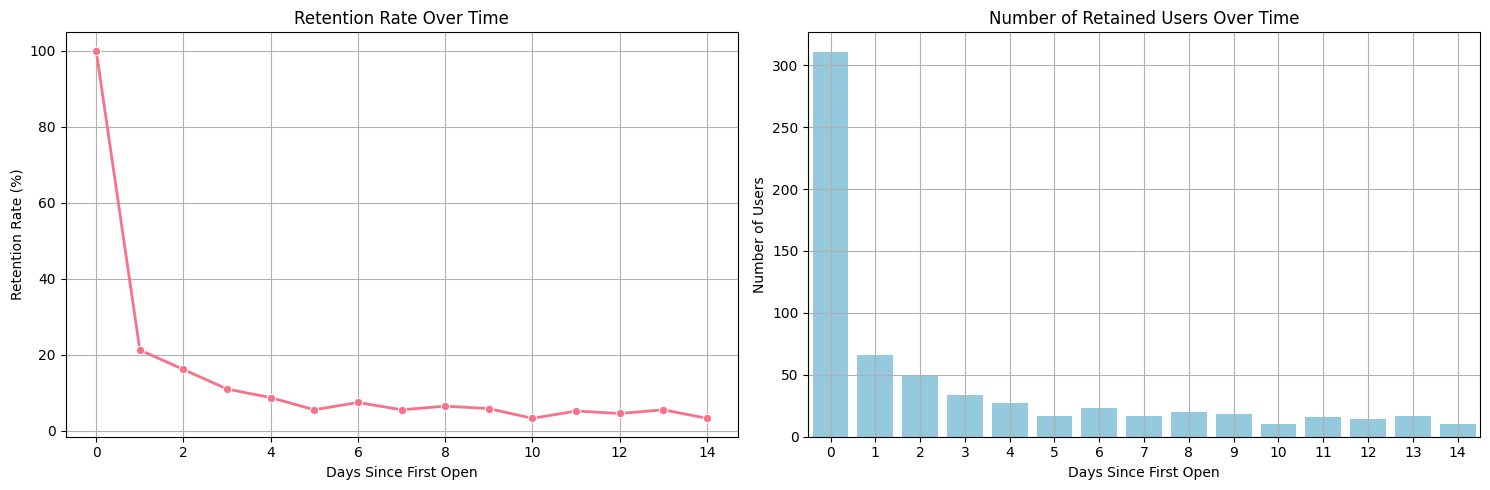

Key Retention Metrics:
Total Users in Cohort: 311
Day 1 Retention: 21.22%
Day 7 Retention: 5.47%
Day 14 Retention: 3.22%

Retention Decay Rate: -3.11% per day


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the style for better visualizations
sns.set_palette("husl")

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 1. Line plot of retention rate over days
sns.lineplot(data=retention, x='days_since_first_open', y='retention_rate', 
             marker='o', linewidth=2, ax=ax1)
ax1.set_title('Retention Rate Over Time')
ax1.set_xlabel('Days Since First Open')
ax1.set_ylabel('Retention Rate (%)')
ax1.grid(True)

# 2. Bar plot of retained users
sns.barplot(data=retention, x='days_since_first_open', y='retained_users', 
            color='skyblue', ax=ax2)
ax2.set_title('Number of Retained Users Over Time')
ax2.set_xlabel('Days Since First Open')
ax2.set_ylabel('Number of Users')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print some key metrics
print("Key Retention Metrics:")
print(f"Total Users in Cohort: {retention['total_users'].iloc[0]}")
print(f"Day 1 Retention: {retention[retention['days_since_first_open'] == 1]['retention_rate'].iloc[0]:.2f}%")
print(f"Day 7 Retention: {retention[retention['days_since_first_open'] == 7]['retention_rate'].iloc[0]:.2f}%")
print(f"Day 14 Retention: {retention[retention['days_since_first_open'] == 14]['retention_rate'].iloc[0]:.2f}%")

# Calculate the retention decay rate
decay_rate = np.polyfit(retention['days_since_first_open'], 
                       retention['retention_rate'], 1)[0]
print(f"\nRetention Decay Rate: {decay_rate:.2f}% per day")

Retention rate từ Day 1 đến Day 5 giảm khá nhanh, và từ Day 5 trở đi thì tăng giảm không đều.

# REVENUE

In [5]:
query = """
WITH revenue AS (SELECT 
	event_name, 
	platform,
	CASE WHEN event_name = 'in_app_purchase' 
		THEN (SELECT value.int_value FROM UNNEST(event_params) WHERE key = 'quantity')
	WHEN event_name = 'ad_impression'
		THEN 1
		END AS quantity,
	CASE WHEN event_name = 'ad_impression' 
		THEN (SELECT value.double_value FROM UNNEST(event_params) WHERE key = 'value')
	WHEN event_name = 'in_app_purchase'
		THEN event_value_in_usd
		-- THEN (SELECT value.int_value FROM UNNEST(event_params) WHERE key = 'value')
		END AS unit_price
FROM `royal-hexa-in-house.pixon_data_science.001_mock`
WHERE (event_name IN ('ad_impression', 'in_app_purchase'))
	AND (event_date BETWEEN '20250110' AND '20250115')
	)
SELECT 
	platform,
	event_name,
	SUM(unit_price) AS revenue
	-- SUM(quantity * unit_price) AS revenue
FROM revenue
GROUP BY platform, event_name
"""

# Execute the query and load results into a pandas DataFrame
revenue = client.query(query).to_dataframe()

/home/hankel/miniconda3/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1900: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [6]:
revenue.head()

,platform,event_name,revenue
0,ANDROID,in_app_purchase,452.043134
1,IOS,in_app_purchase,41.620604
2,ANDROID,ad_impression,1797.628352
3,IOS,ad_impression,302.373322


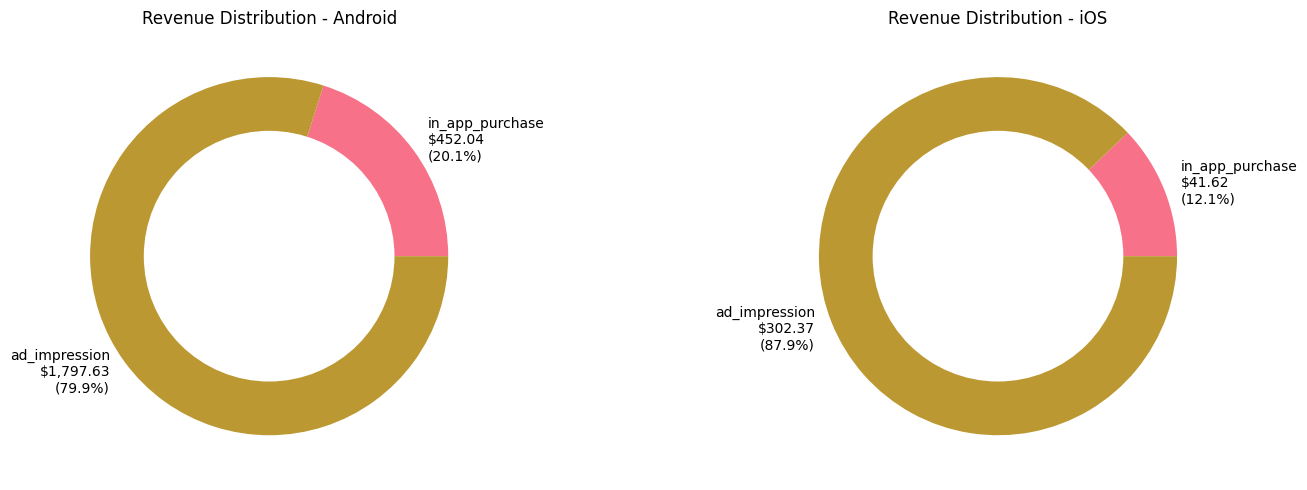


Revenue Totals by Platform:
Android Total Revenue: $2,249.67
iOS Total Revenue: $343.99


In [7]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Data for Android
android_data = revenue[revenue['platform'] == 'ANDROID']
# Data for iOS
ios_data = revenue[revenue['platform'] == 'IOS']

# Function to create donut plot with both percentage and absolute values
def create_donut(data, ax, title):
    # Calculate total for percentage
    total = data['revenue'].sum()
    
    # Create labels with both percentage and absolute values
    labels = [f'{row["event_name"]}\n${row["revenue"]:,.2f}\n({row["revenue"]/total*100:.1f}%)' 
             for _, row in data.iterrows()]
    
    wedges, texts, autotexts = ax.pie(data['revenue'], 
                                     labels=labels,
                                     autopct='',  # Remove default percentage
                                     pctdistance=0.85)
    
    # Create a circle at the center to make it a donut chart
    centre_circle = plt.Circle((0,0), 0.70, fc='white')
    ax.add_artist(centre_circle)
    ax.set_title(title)

# Create donut plots for both platforms
create_donut(android_data, ax1, 'Revenue Distribution - Android')
create_donut(ios_data, ax2, 'Revenue Distribution - iOS')

plt.tight_layout()
plt.show()

# Print revenue totals for each platform
print("\nRevenue Totals by Platform:")
print(f"Android Total Revenue: ${android_data['revenue'].sum():,.2f}")
print(f"iOS Total Revenue: ${ios_data['revenue'].sum():,.2f}")

Revenue từ ngày 10 tới ngày 15 chủ yếu nằm ở nền tảng Android, và chủ yếu đến từ ads thay vì iap.

# USERS BY COUNTRY AND PLATFORM

In [8]:
# Query 1: Daily metrics (for time series analysis)
query_daily = """
WITH user_metrics AS (
  SELECT 
    user_pseudo_id,
    platform,
    country,
    event_date,
    COUNT(DISTINCT CASE WHEN event_name = 'session_start' THEN event_timestamp END) as session_count,
    COUNT(DISTINCT event_name) as unique_events,
    COUNT(*) as total_events,
    COUNT(DISTINCT CASE WHEN event_name = 'in_app_purchase' THEN 1 END) as purchase_count,
    SUM(CASE WHEN event_name = 'in_app_purchase' THEN event_value_in_usd ELSE 0 END) as purchase_revenue,
    SUM(CASE 
      WHEN event_name = 'ad_impression' THEN (
        SELECT value.double_value 
        FROM UNNEST(event_params) 
        WHERE key = 'value'
      )
      ELSE 0 
    END) as ad_revenue,
    AVG(CASE WHEN event_name = 'in_app_purchase' THEN event_value_in_usd ELSE NULL END) as avg_purchase_value,
    COUNT(DISTINCT CASE WHEN event_name = 'first_open' THEN user_pseudo_id END) as new_users
  FROM `royal-hexa-in-house.pixon_data_science.001_mock`
  GROUP BY user_pseudo_id, platform, country, event_date
)
SELECT 
  event_date,
  platform,
  country,
  -- User counts
  COUNT(DISTINCT user_pseudo_id) as total_users,
  COUNT(DISTINCT CASE WHEN session_count > 0 THEN user_pseudo_id END) as active_users,
  COUNT(DISTINCT CASE WHEN purchase_count > 0 THEN user_pseudo_id END) as paying_users,
  SUM(new_users) as new_users,
  
  -- Engagement metrics
  AVG(session_count) as avg_sessions_per_user,
  AVG(unique_events) as avg_unique_events_per_user,
  AVG(total_events) as avg_total_events_per_user,
  
  -- Revenue metrics
  SUM(purchase_revenue) as total_purchase_revenue,
  SUM(ad_revenue) as total_ad_revenue,
  SUM(purchase_revenue + ad_revenue) as total_revenue,
  AVG(CASE WHEN purchase_count > 0 THEN purchase_revenue ELSE NULL END) as avg_revenue_per_paying_user,
  SUM(purchase_revenue + ad_revenue) / NULLIF(COUNT(DISTINCT user_pseudo_id), 0) as arpu,
  SUM(purchase_revenue + ad_revenue) / NULLIF(COUNT(DISTINCT CASE WHEN purchase_count > 0 THEN user_pseudo_id END), 0) as arppu,
  
  -- Conversion metrics
  COUNT(DISTINCT CASE WHEN purchase_count > 0 THEN user_pseudo_id END) / NULLIF(COUNT(DISTINCT user_pseudo_id), 0) as conversion_rate,
  
  -- Purchase metrics
  AVG(purchase_count) as avg_purchases_per_user,
  AVG(CASE WHEN purchase_count > 0 THEN purchase_count ELSE NULL END) as avg_purchases_per_paying_user,
  AVG(avg_purchase_value) as avg_purchase_value,
  
  -- Ad metrics
  COUNT(DISTINCT CASE WHEN ad_revenue > 0 THEN user_pseudo_id END) as users_with_ads,
  SUM(ad_revenue) / NULLIF(COUNT(DISTINCT user_pseudo_id), 0) as ad_revenue_per_user
FROM user_metrics
GROUP BY event_date, platform, country
ORDER BY event_date, platform, country;
"""

# Query 2: Overall platform-country metrics
query_overall = """
WITH user_metrics AS (
  SELECT 
    user_pseudo_id,
    platform,
    country,
    COUNT(DISTINCT CASE WHEN event_name = 'session_start' THEN event_timestamp END) as session_count,
    COUNT(DISTINCT event_name) as unique_events,
    COUNT(*) as total_events,
    COUNT(DISTINCT CASE WHEN event_name = 'in_app_purchase' THEN 1 END) as purchase_count,
    SUM(CASE WHEN event_name = 'in_app_purchase' THEN event_value_in_usd ELSE 0 END) as purchase_revenue,
    SUM(CASE 
      WHEN event_name = 'ad_impression' THEN (
        SELECT value.double_value 
        FROM UNNEST(event_params) 
        WHERE key = 'value'
      )
      ELSE 0 
    END) as ad_revenue,
    AVG(CASE WHEN event_name = 'in_app_purchase' THEN event_value_in_usd ELSE NULL END) as avg_purchase_value
  FROM `royal-hexa-in-house.pixon_data_science.001_mock`
  GROUP BY user_pseudo_id, platform, country
)
SELECT 
  platform,
  country,
  -- User counts
  COUNT(DISTINCT user_pseudo_id) as total_users,
  COUNT(DISTINCT CASE WHEN session_count > 0 THEN user_pseudo_id END) as active_users,
  COUNT(DISTINCT CASE WHEN purchase_count > 0 THEN user_pseudo_id END) as paying_users,
  
  -- Engagement metrics
  AVG(session_count) as avg_sessions_per_user,
  AVG(unique_events) as avg_unique_events_per_user,
  AVG(total_events) as avg_total_events_per_user,
  
  -- Revenue metrics
  SUM(purchase_revenue) as total_purchase_revenue,
  SUM(ad_revenue) as total_ad_revenue,
  SUM(purchase_revenue + ad_revenue) as total_revenue,
  AVG(CASE WHEN purchase_count > 0 THEN purchase_revenue ELSE NULL END) as avg_revenue_per_paying_user,
  SUM(purchase_revenue + ad_revenue) / NULLIF(COUNT(DISTINCT user_pseudo_id), 0) as arpu,
  SUM(purchase_revenue + ad_revenue) / NULLIF(COUNT(DISTINCT CASE WHEN purchase_count > 0 THEN user_pseudo_id END), 0) as arppu,
  
  -- Conversion metrics
  COUNT(DISTINCT CASE WHEN purchase_count > 0 THEN user_pseudo_id END) / NULLIF(COUNT(DISTINCT user_pseudo_id), 0) as conversion_rate,
  
  -- Purchase metrics
  AVG(purchase_count) as avg_purchases_per_user,
  AVG(CASE WHEN purchase_count > 0 THEN purchase_count ELSE NULL END) as avg_purchases_per_paying_user,
  AVG(avg_purchase_value) as avg_purchase_value,
  
  -- Ad metrics
  COUNT(DISTINCT CASE WHEN ad_revenue > 0 THEN user_pseudo_id END) as users_with_ads,
  SUM(ad_revenue) / NULLIF(COUNT(DISTINCT user_pseudo_id), 0) as ad_revenue_per_user
FROM user_metrics
GROUP BY platform, country
ORDER BY platform, country;
"""

# Execute both queries
df_daily = client.query(query_daily).to_dataframe()
df_overall = client.query(query_overall).to_dataframe()

# Calculate additional metrics for overall analysis
df_overall['purchase_revenue_ratio'] = df_overall['total_purchase_revenue'] / df_overall['total_revenue']

/home/hankel/miniconda3/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1900: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [9]:
df_overall.head()

,platform,country,total_users,active_users,paying_users,avg_sessions_per_user,avg_unique_events_per_user,avg_total_events_per_user,total_purchase_revenue,total_ad_revenue,...,avg_revenue_per_paying_user,arpu,arppu,conversion_rate,avg_purchases_per_user,avg_purchases_per_paying_user,avg_purchase_value,users_with_ads,ad_revenue_per_user,purchase_revenue_ratio
0,ANDROID,Australia,2,0,2,0.000000,1.000000,1.500000,24.394499,0.000000,...,12.197249,12.197249,12.197249,1.000000,1.000000,1.0,8.546273,0,0.000000,1.000000
1,ANDROID,Canada,345,305,1,8.492754,22.959420,1542.011594,11.298872,438.220987,...,11.298872,1.302956,449.519859,0.002899,0.002899,1.0,11.298872,284,1.270206,0.025135
2,ANDROID,Germany,11,0,11,0.000000,1.000000,2.454545,140.048914,0.000000,...,12.731719,12.731719,12.731719,1.000000,1.000000,1.0,4.645427,0,0.000000,1.000000
3,ANDROID,Japan,2896,2703,13,9.784530,26.340815,1692.576312,250.737623,2334.174037,...,19.287509,0.892580,198.839358,0.004489,0.004489,1.0,4.075265,2615,0.805999,0.097000
4,ANDROID,New Zealand,1,0,1,0.000000,1.000000,1.000000,4.904729,0.000000,...,4.904729,4.904729,4.904729,1.000000,1.000000,1.0,4.904729,0,0.000000,1.000000


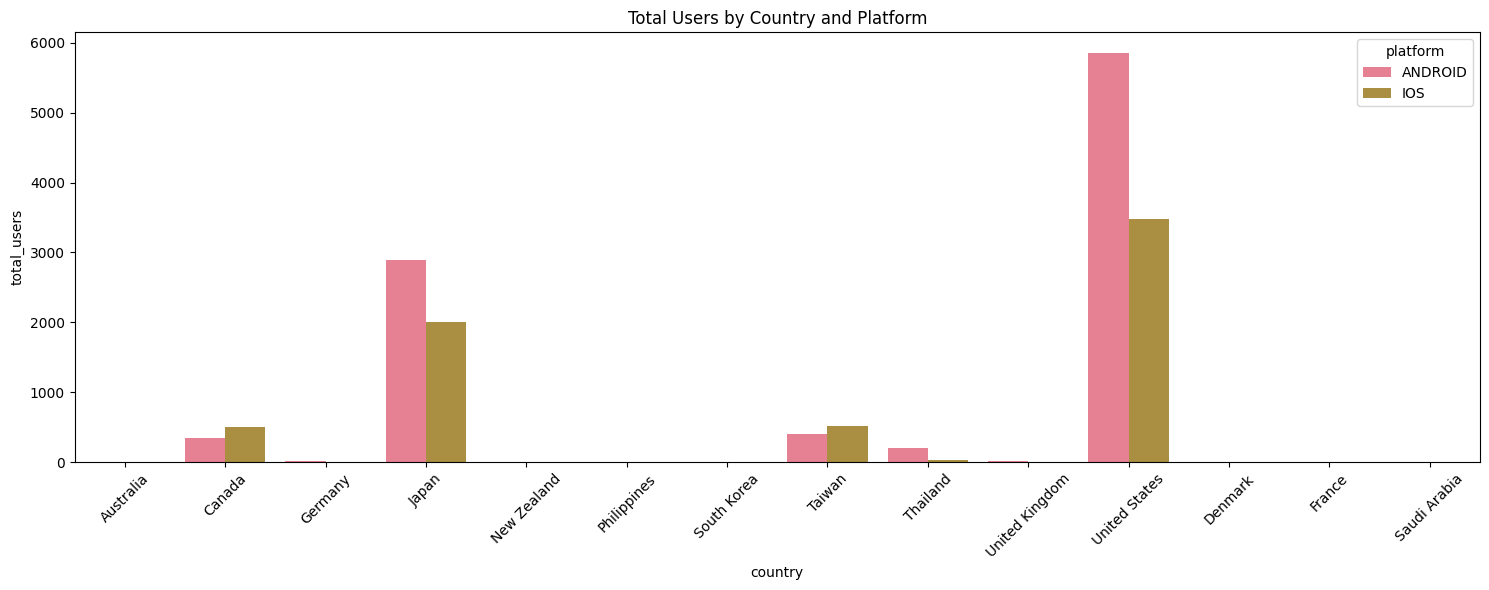

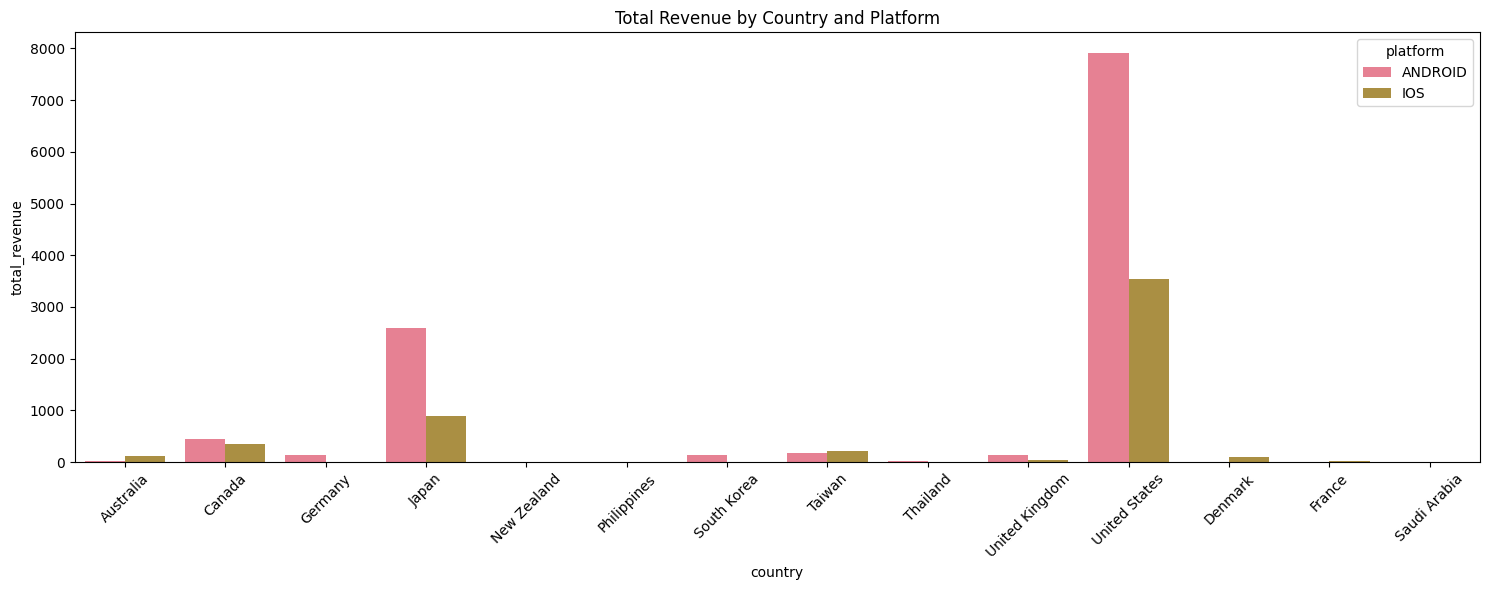

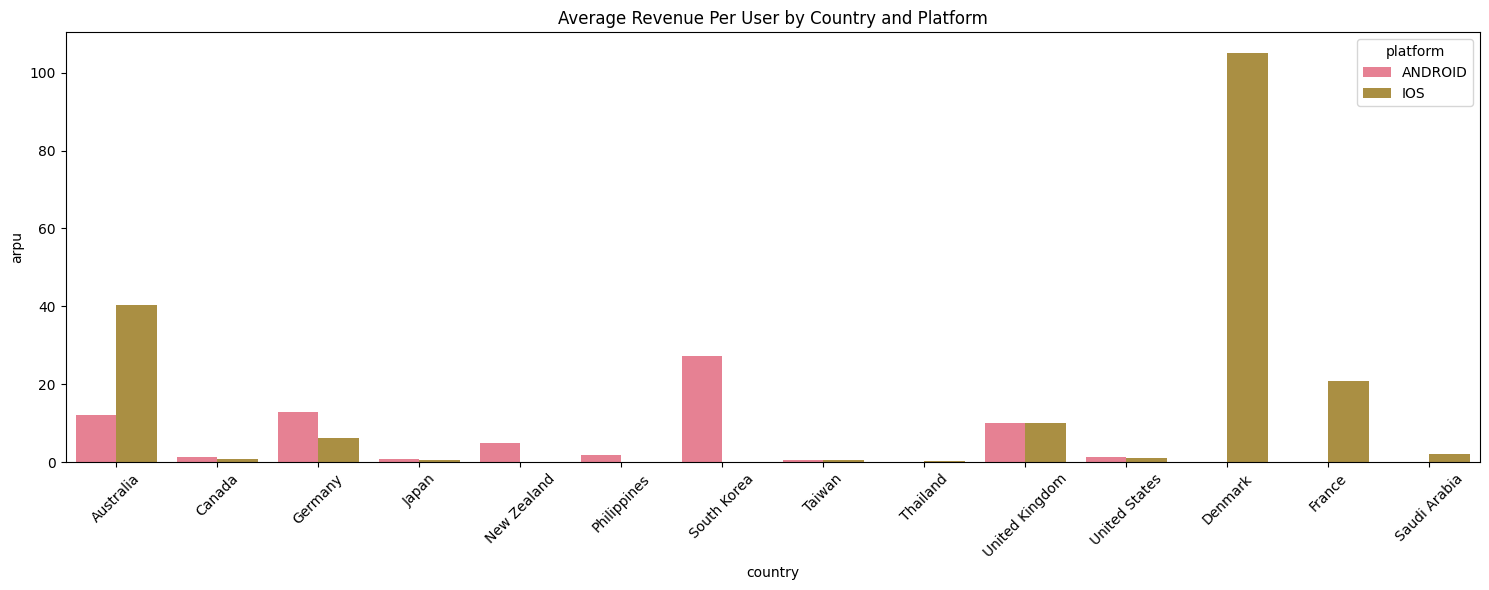

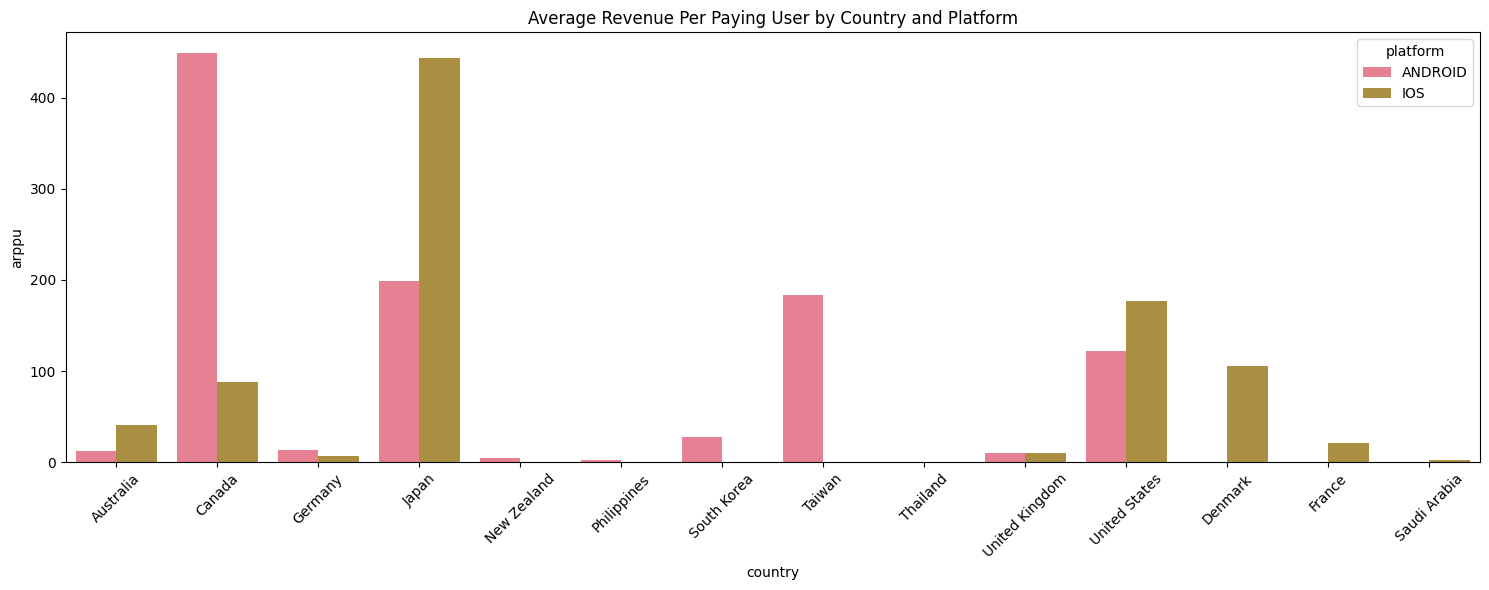

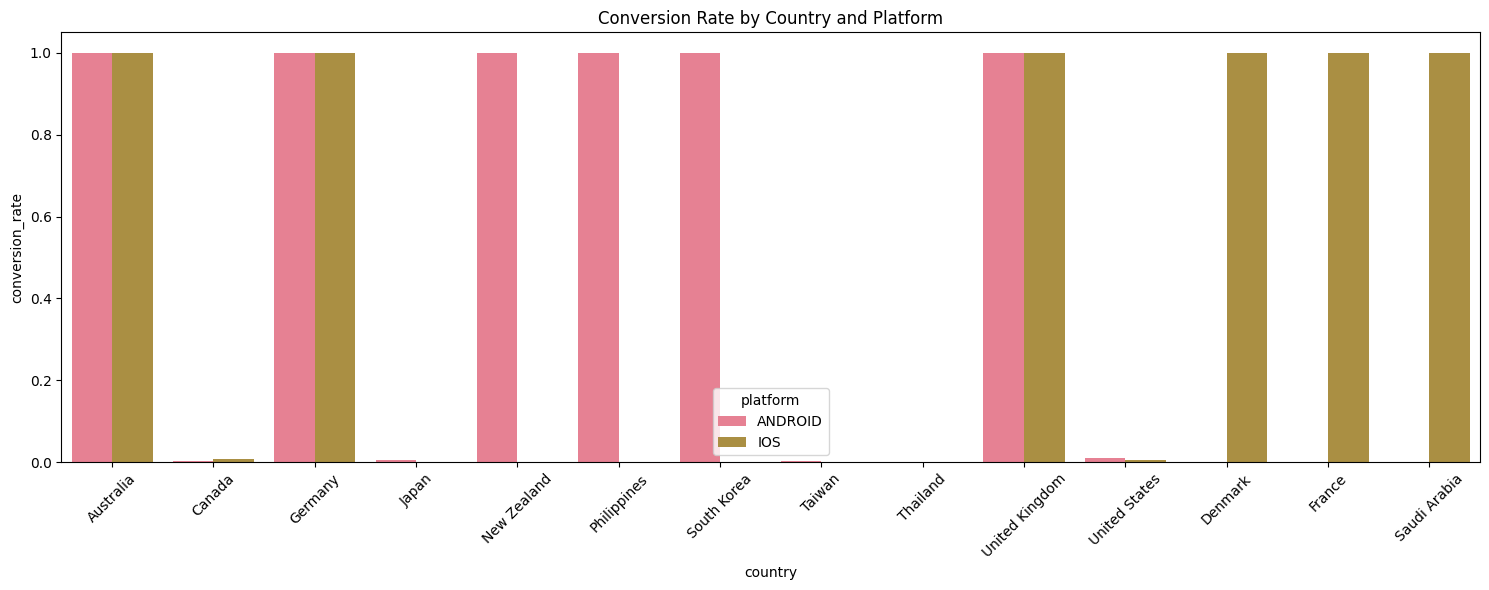

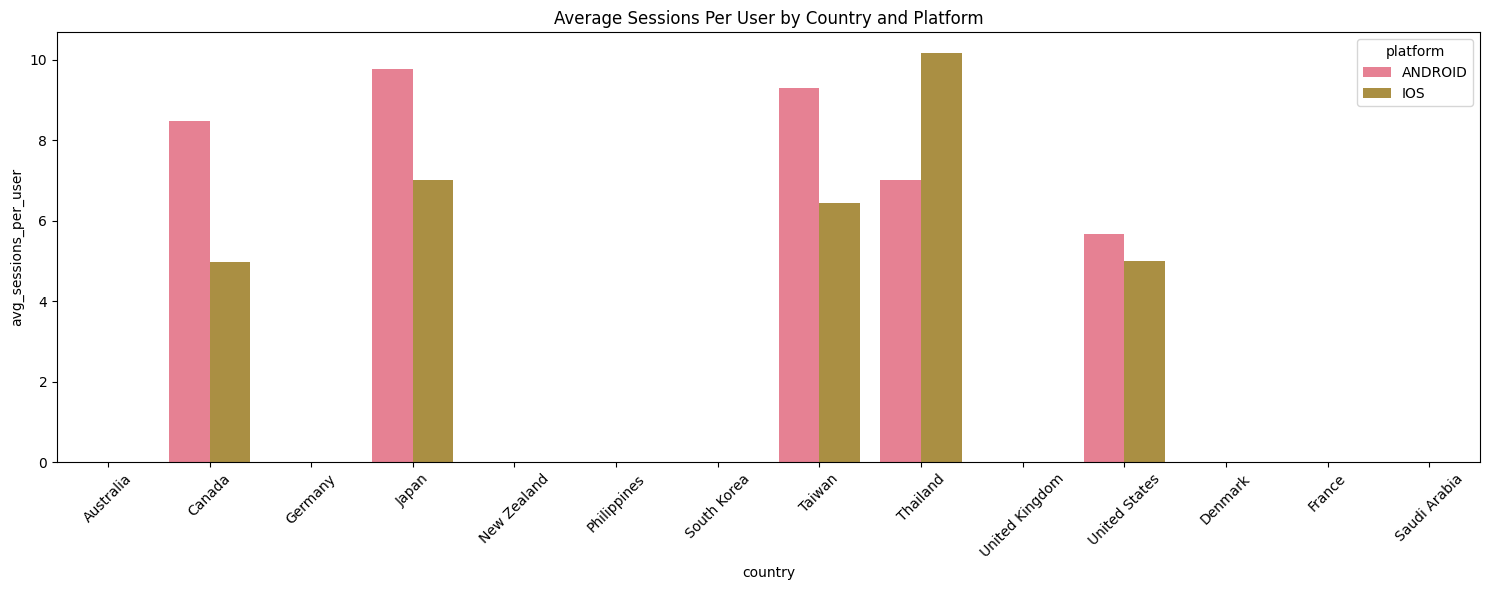

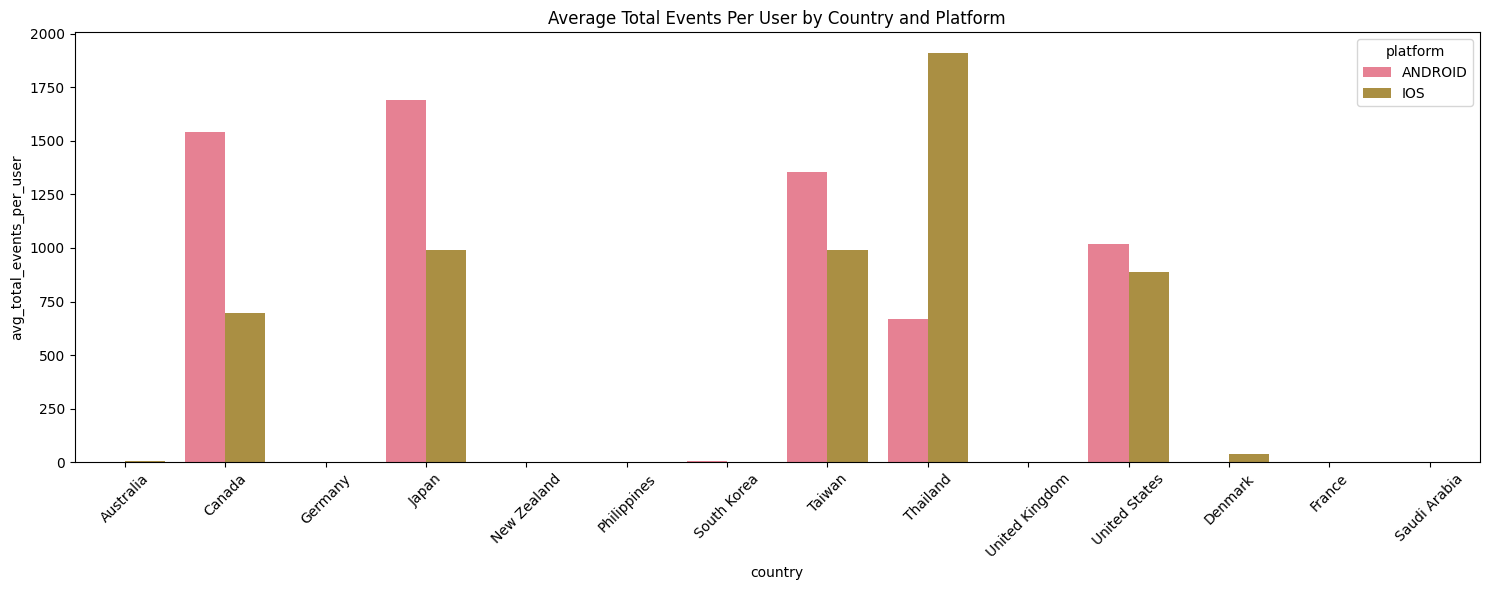

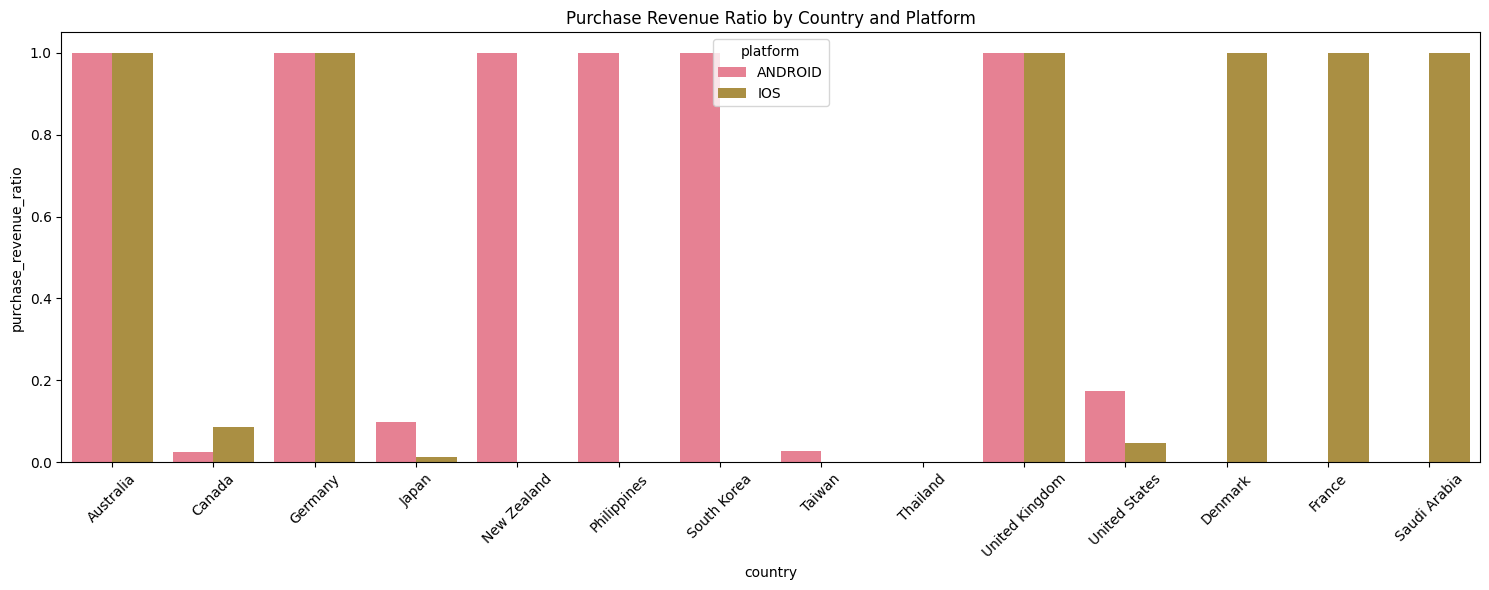


=== MARKET ANALYSIS SUMMARY ===

1. SCALE METRICS

Top 5 Countries by Total Users:
country
United States    9337
Japan            4905
Taiwan            912
Canada            841
Thailand          224
Name: total_users, dtype: Int64

Top 5 Countries by Total Revenue:
country
United States     11464.298097
Japan              3472.687677
Canada              800.931984
Taiwan              391.424322
United Kingdom      178.686310
Name: total_revenue, dtype: float64

2. MONETIZATION METRICS

Top 5 Countries by ARPU:
country
Denmark           105.119537
South Korea        27.215375
Australia          26.285826
France             20.811192
United Kingdom      9.930413
Name: arpu, dtype: float64

Top 5 Countries by ARPPU:
country
Japan            321.363683
Canada           268.686445
Taiwan           183.186063
United States    149.596053
Denmark          105.119537
Name: arppu, dtype: float64

Top 5 Countries by Conversion Rate:
country
Australia      1.0
Denmark        1.0
Germany        

In [14]:
# Calculate total revenue and revenue mix
df_overall['total_revenue'] = df_overall['total_purchase_revenue'] + df_overall['total_ad_revenue']
df_overall['purchase_revenue_ratio'] = df_overall['total_purchase_revenue'] / df_overall['total_revenue']

# 1. Scale Metrics
plt.figure(figsize=(15, 6))
sns.barplot(data=df_overall, x='country', y='total_users', hue='platform')
plt.title('Total Users by Country and Platform')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))
sns.barplot(data=df_overall, x='country', y='total_revenue', hue='platform')
plt.title('Total Revenue by Country and Platform')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Monetization Metrics
plt.figure(figsize=(15, 6))
sns.barplot(data=df_overall, x='country', y='arpu', hue='platform')
plt.title('Average Revenue Per User by Country and Platform')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))
sns.barplot(data=df_overall, x='country', y='arppu', hue='platform')
plt.title('Average Revenue Per Paying User by Country and Platform')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))
sns.barplot(data=df_overall, x='country', y='conversion_rate', hue='platform')
plt.title('Conversion Rate by Country and Platform')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Engagement Metrics
plt.figure(figsize=(15, 6))
sns.barplot(data=df_overall, x='country', y='avg_sessions_per_user', hue='platform')
plt.title('Average Sessions Per User by Country and Platform')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))
sns.barplot(data=df_overall, x='country', y='avg_total_events_per_user', hue='platform')
plt.title('Average Total Events Per User by Country and Platform')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Revenue Mix
plt.figure(figsize=(15, 6))
sns.barplot(data=df_overall, x='country', y='purchase_revenue_ratio', hue='platform')
plt.title('Purchase Revenue Ratio by Country and Platform')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Comprehensive Summary
print("\n=== MARKET ANALYSIS SUMMARY ===")

# 1. Scale Analysis
print("\n1. SCALE METRICS")
print("\nTop 5 Countries by Total Users:")
print(df_overall.groupby('country')['total_users'].sum().sort_values(ascending=False).head())
print("\nTop 5 Countries by Total Revenue:")
print(df_overall.groupby('country')['total_revenue'].sum().sort_values(ascending=False).head())

# 2. Monetization Analysis
print("\n2. MONETIZATION METRICS")
print("\nTop 5 Countries by ARPU:")
print(df_overall.groupby('country')['arpu'].mean().sort_values(ascending=False).head())
print("\nTop 5 Countries by ARPPU:")
print(df_overall.groupby('country')['arppu'].mean().sort_values(ascending=False).head())
print("\nTop 5 Countries by Conversion Rate:")
print(df_overall.groupby('country')['conversion_rate'].mean().sort_values(ascending=False).head())

# 3. Engagement Analysis
print("\n3. ENGAGEMENT METRICS")
print("\nTop 5 Countries by Average Sessions:")
print(df_overall.groupby('country')['avg_sessions_per_user'].mean().sort_values(ascending=False).head())
print("\nTop 5 Countries by Average Unique Events:")
print(df_overall.groupby('country')['avg_unique_events_per_user'].mean().sort_values(ascending=False).head())

# 4. Revenue Mix Analysis
print("\n4. REVENUE MIX")
print("\nTop 5 Countries by Purchase Revenue:")
print(df_overall.groupby('country')['total_purchase_revenue'].sum().sort_values(ascending=False).head())
print("\nTop 5 Countries by Ad Revenue:")
print(df_overall.groupby('country')['total_ad_revenue'].sum().sort_values(ascending=False).head())

# 5. Platform Performance
print("\n5. PLATFORM PERFORMANCE")
print("\nOverall Platform Metrics:")
print(df_overall.groupby('platform').agg({
    'total_revenue': 'sum',
    'total_users': 'sum',
    'conversion_rate': 'mean',
    'arpu': 'mean',
    'arppu': 'mean',
    'avg_sessions_per_user': 'mean',
    'avg_unique_events_per_user': 'mean'
}).round(4))

# 6. Market Opportunity Matrix
print("\n6. MARKET OPPORTUNITY MATRIX")
# Calculate composite score for each country
df_overall['market_score'] = (
    df_overall['total_revenue'].rank(pct=True) * 0.3 +
    df_overall['arpu'].rank(pct=True) * 0.2 +
    df_overall['conversion_rate'].rank(pct=True) * 0.2 +
    df_overall['avg_sessions_per_user'].rank(pct=True) * 0.15 +
    df_overall['avg_unique_events_per_user'].rank(pct=True) * 0.15
)

print("\nTop 5 Countries by Market Opportunity Score:")
print(df_overall.groupby('country')['market_score'].mean().sort_values(ascending=False).head())

Xét theo total performance trong tháng 1, US, Japan, Canada và Taiwan là 4 country với performance tốt nhất in term of total user, revenue và avg revenue trên mỗi người dùng có purchase. Các chỉ số engagement như session và số lượng event tương tác cũng rất tốt.

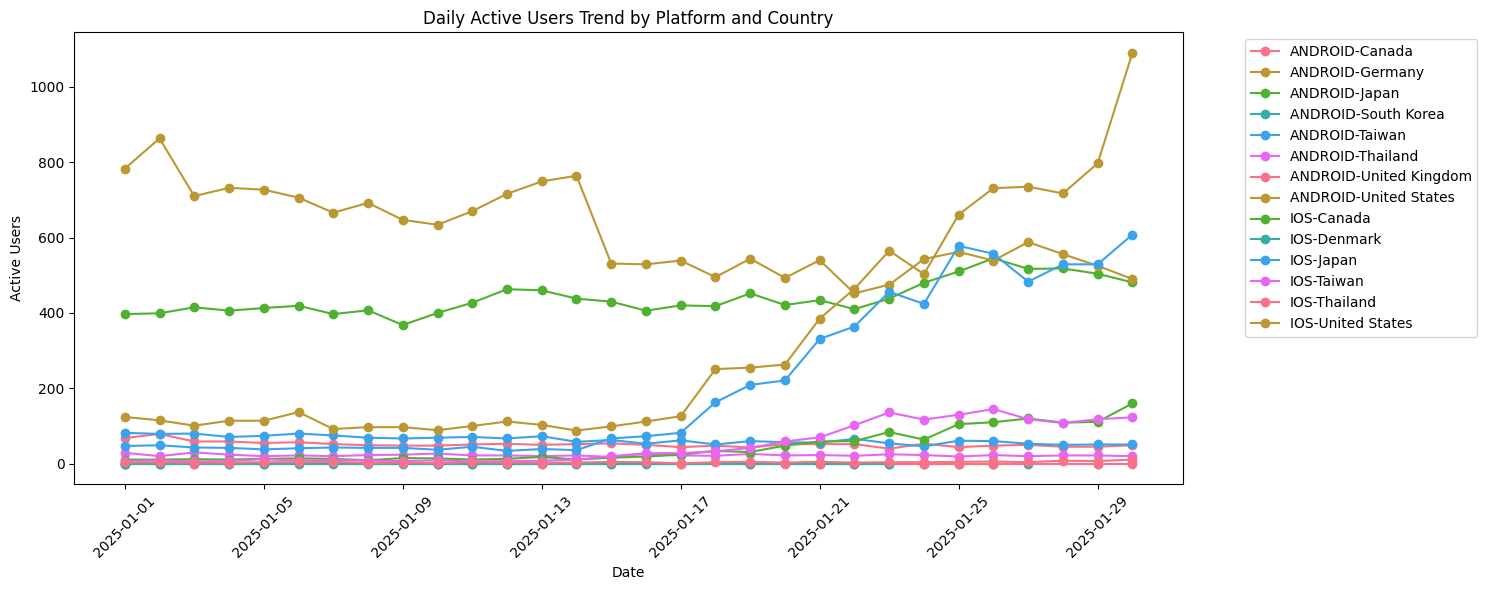

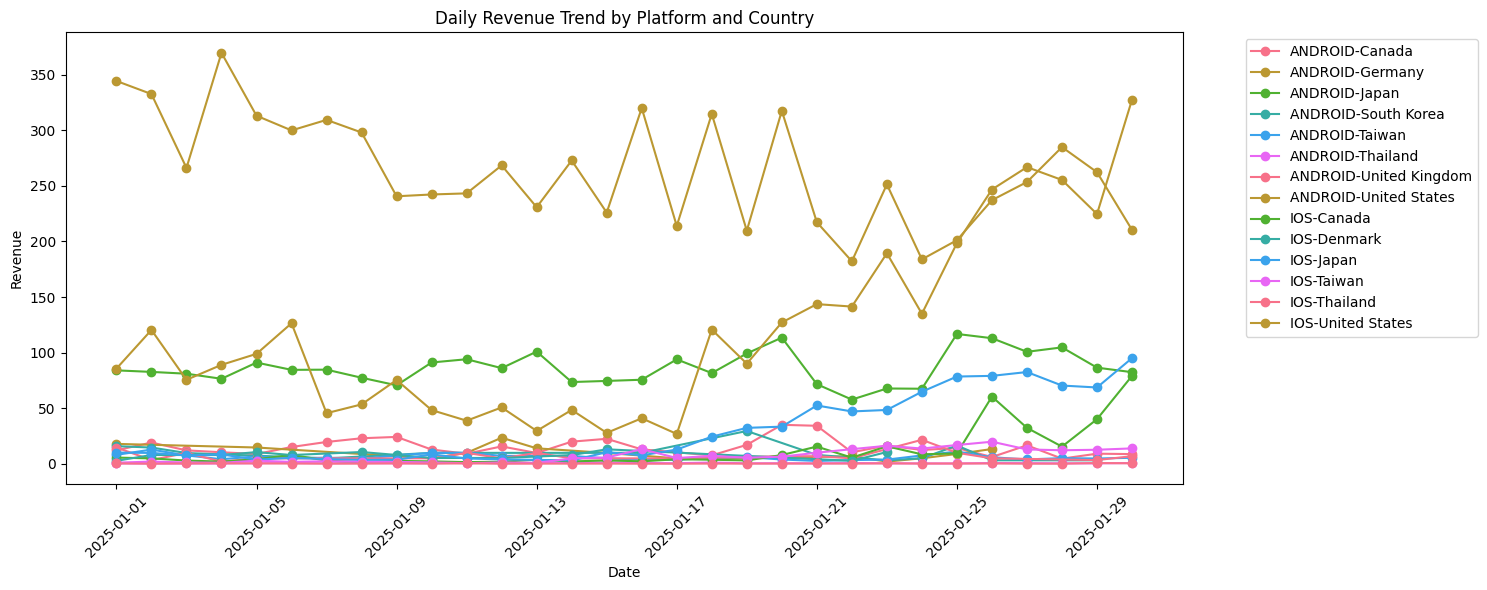


=== GROWTH ANALYSIS ===

Top 5 Countries by User Growth Rate:
   platform        country  total_users  active_users_growth_rate  \
11      IOS         Taiwan         1561                 57.142857   
8       IOS         Canada         1365                 46.708464   
10      IOS          Japan         6399                 41.159208   
13      IOS  United States         9585                 26.863181   
12      IOS       Thailand          132                  6.034483   

    total_revenue_growth_rate  paying_users_growth_rate  \
11                  44.565271                  0.000000   
8                   45.545834                  0.000000   
10                  28.979247                  0.000000   
13                   9.744235                  3.448276   
12                   1.191225                  0.000000   

    conversion_rate_growth_rate  
11                      0.00000  
8                       0.00000  
10                      0.00000  
13                     -2.67512

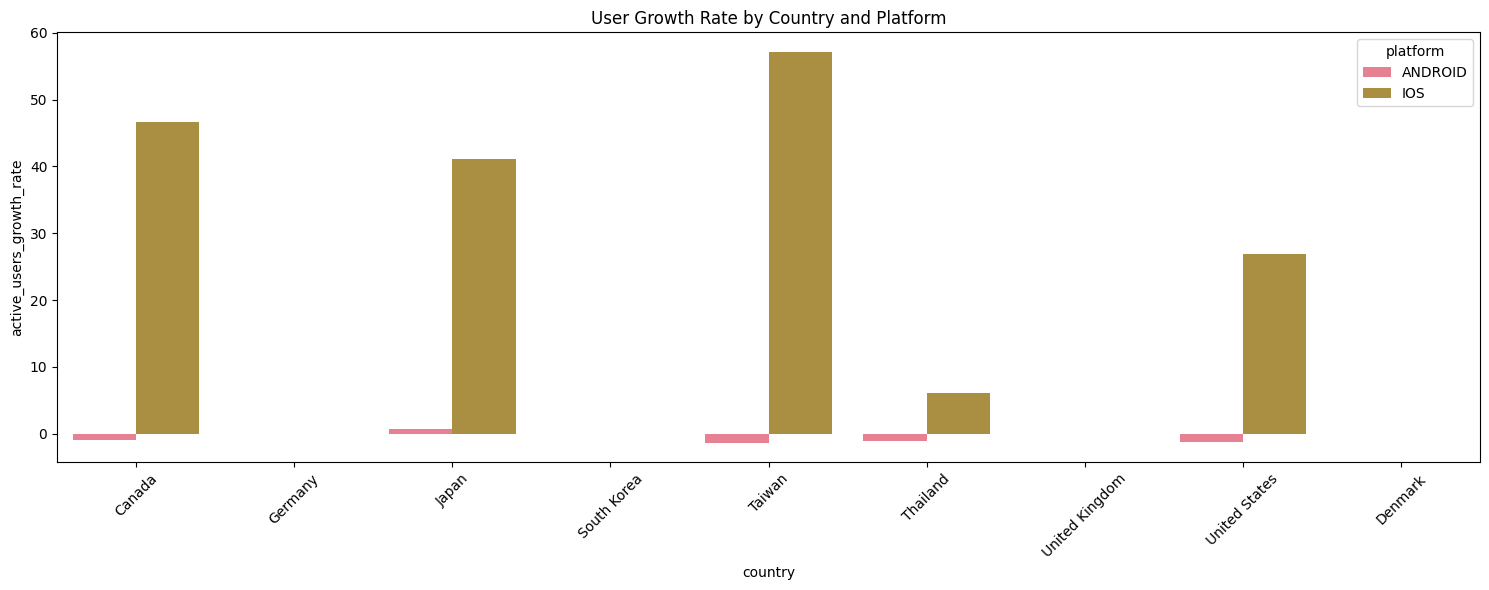

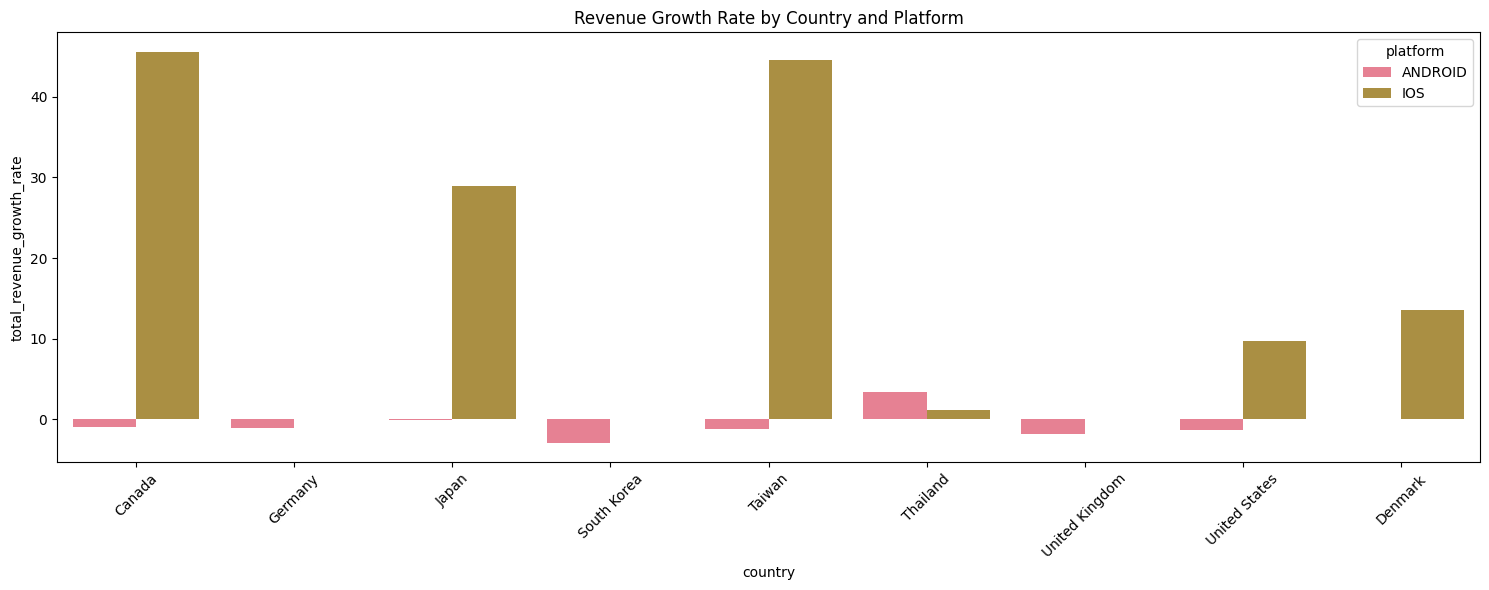


=== CONSISTENT GROWTH MARKETS ===

Markets with Positive Growth in All Metrics:
   platform        country  total_users  active_users_growth_rate  \
13      IOS  United States         9585                 26.863181   

    total_revenue_growth_rate  paying_users_growth_rate  \
13                   9.744235                  3.448276   

    conversion_rate_growth_rate  consistent_growth  
13                     -2.67512               True  


In [11]:
# Convert event_date to datetime
df_daily['event_date'] = pd.to_datetime(df_daily['event_date'])

# 1. Daily Active Users (DAU) Trend
plt.figure(figsize=(15, 6))
for (platform, country), group in df_daily.groupby(['platform', 'country']):
    if group['total_users'].sum() >= 10:  # Filter for countries with sufficient users
        plt.plot(group['event_date'], group['active_users'], 
                label=f'{platform}-{country}', marker='o')
plt.title('Daily Active Users Trend by Platform and Country')
plt.xlabel('Date')
plt.ylabel('Active Users')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Revenue Trend
plt.figure(figsize=(15, 6))
for (platform, country), group in df_daily.groupby(['platform', 'country']):
    if group['total_users'].sum() >= 10:  # Filter for countries with sufficient users
        plt.plot(group['event_date'], group['total_revenue'], 
                label=f'{platform}-{country}', marker='o')
plt.title('Daily Revenue Trend by Platform and Country')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Calculate Growth Rates
def calculate_growth_rate(group, metric):
    first_value = group[metric].iloc[0]
    last_value = group[metric].iloc[-1]
    days = (group['event_date'].max() - group['event_date'].min()).days
    if days > 0 and first_value > 0:  # Added check for first_value > 0
        return ((last_value - first_value) / first_value) * 100 / days
    return 0

# Calculate daily growth rates for key metrics
growth_metrics = ['active_users', 'total_revenue', 'paying_users', 'conversion_rate']
growth_rates = []

for (platform, country), group in df_daily.groupby(['platform', 'country']):
    if group['total_users'].sum() >= 10:  # Filter for countries with sufficient users
        growth_data = {
            'platform': platform,
            'country': country,
            'total_users': group['total_users'].sum()
        }
        for metric in growth_metrics:
            growth_data[f'{metric}_growth_rate'] = calculate_growth_rate(group, metric)
        growth_rates.append(growth_data)

growth_df = pd.DataFrame(growth_rates)

# Display growth rates
print("\n=== GROWTH ANALYSIS ===")
print("\nTop 5 Countries by User Growth Rate:")
print(growth_df.sort_values('active_users_growth_rate', ascending=False).head())

print("\nTop 5 Countries by Revenue Growth Rate:")
print(growth_df.sort_values('total_revenue_growth_rate', ascending=False).head())

print("\nTop 5 Countries by Paying User Growth Rate:")
print(growth_df.sort_values('paying_users_growth_rate', ascending=False).head())

# 4. Visualize Growth Rates
plt.figure(figsize=(15, 6))
sns.barplot(data=growth_df, x='country', y='active_users_growth_rate', hue='platform')
plt.title('User Growth Rate by Country and Platform')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))
sns.barplot(data=growth_df, x='country', y='total_revenue_growth_rate', hue='platform')
plt.title('Revenue Growth Rate by Country and Platform')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. Identify Consistent Growth
growth_df['consistent_growth'] = (
    (growth_df['active_users_growth_rate'] > 0) & 
    (growth_df['total_revenue_growth_rate'] > 0) & 
    (growth_df['paying_users_growth_rate'] > 0)
)

print("\n=== CONSISTENT GROWTH MARKETS ===")
print("\nMarkets with Positive Growth in All Metrics:")
print(growth_df[growth_df['consistent_growth']].sort_values('total_revenue_growth_rate', ascending=False))

In [12]:
df_daily.head()

,event_date,platform,country,total_users,active_users,paying_users,new_users,avg_sessions_per_user,avg_unique_events_per_user,avg_total_events_per_user,...,total_revenue,avg_revenue_per_paying_user,arpu,arppu,conversion_rate,avg_purchases_per_user,avg_purchases_per_paying_user,avg_purchase_value,users_with_ads,ad_revenue_per_user
0,2025-01-01,ANDROID,Canada,72,68,0,4,1.750000,19.541667,281.472222,...,12.143622,NaN,0.168661,NaN,0.00000,0.00000,NaN,NaN,66,0.168661
1,2025-01-01,ANDROID,Germany,3,0,3,0,0.000000,1.000000,1.333333,...,17.904515,5.968172,5.968172,5.968172,1.00000,1.00000,1.0,4.347744,0,0.000000
2,2025-01-01,ANDROID,Japan,415,397,1,70,1.886747,20.349398,346.532530,...,84.034149,5.726682,0.202492,84.034149,0.00241,0.00241,1.0,5.726682,378,0.188693
3,2025-01-01,ANDROID,South Korea,2,0,2,0,0.000000,1.000000,1.000000,...,15.864768,7.932384,7.932384,7.932384,1.00000,1.00000,1.0,7.932384,0,0.000000
4,2025-01-01,ANDROID,Taiwan,86,82,0,8,1.988372,19.127907,246.616279,...,8.050862,NaN,0.093615,NaN,0.00000,0.00000,NaN,NaN,78,0.093615


In [13]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Get unique platforms
platforms = df_daily['platform'].unique()

# 1. Daily Active Users (DAU) Trend with Platform Dropdown
fig_dau = go.Figure()

# Add traces for each platform-country combination
for platform in platforms:
    platform_data = df_daily[df_daily['platform'] == platform]
    for country in platform_data['country'].unique():
        country_data = platform_data[platform_data['country'] == country]
        fig_dau.add_trace(go.Scatter(
            x=country_data['event_date'],
            y=country_data['active_users'],
            name=f'{platform}-{country}',
            mode='lines+markers',
            visible=True if platform == platforms[0] else False
        ))

# Create dropdown buttons
buttons = []
for platform in platforms:
    visibility = [True if trace.name.startswith(platform) else False for trace in fig_dau.data]
    buttons.append(dict(
        args=[{"visible": visibility}],
        label=platform,
        method="update"
    ))

fig_dau.update_layout(
    updatemenus=[dict(
        buttons=buttons,
        direction="down",
        showactive=True,
        x=1.0,
        y=1.0,
        xanchor="right",
        yanchor="top"
    )],
    title='Daily Active Users Trend by Country and Platform',
    xaxis_title="Date",
    yaxis_title="Active Users",
    showlegend=True,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=1.05
    )
)
fig_dau.show()

# 2. New Users Trend with Platform Dropdown
fig_dau = go.Figure()

# Add traces for each platform-country combination
for platform in platforms:
    platform_data = df_daily[df_daily['platform'] == platform]
    for country in platform_data['country'].unique():
        country_data = platform_data[platform_data['country'] == country]
        fig_dau.add_trace(go.Scatter(
            x=country_data['event_date'],
            y=country_data['new_users'],
            name=f'{platform}-{country}',
            mode='lines+markers',
            visible=True if platform == platforms[0] else False
        ))

# Create dropdown buttons
buttons = []
for platform in platforms:
    visibility = [True if trace.name.startswith(platform) else False for trace in fig_dau.data]
    buttons.append(dict(
        args=[{"visible": visibility}],
        label=platform,
        method="update"
    ))

fig_dau.update_layout(
    updatemenus=[dict(
        buttons=buttons,
        direction="down",
        showactive=True,
        x=1.0,
        y=1.0,
        xanchor="right",
        yanchor="top"
    )],
    title='Daily New Users Trend by Country and Platform',
    xaxis_title="Date",
    yaxis_title="New Users",
    showlegend=True,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=1.05
    )
)
fig_dau.show()

# 3. Revenue Trend with Platform Dropdown
fig_revenue = go.Figure()

# Add traces for each platform-country combination
for platform in platforms:
    platform_data = df_daily[df_daily['platform'] == platform]
    for country in platform_data['country'].unique():
        country_data = platform_data[platform_data['country'] == country]
        fig_revenue.add_trace(go.Scatter(
            x=country_data['event_date'],
            y=country_data['total_revenue'],
            name=f'{platform}-{country}',
            mode='lines+markers',
            visible=True if platform == platforms[0] else False
        ))

# Create dropdown buttons
buttons = []
for platform in platforms:
    visibility = [True if trace.name.startswith(platform) else False for trace in fig_revenue.data]
    buttons.append(dict(
        args=[{"visible": visibility}],
        label=platform,
        method="update"
    ))

fig_revenue.update_layout(
    updatemenus=[dict(
        buttons=buttons,
        direction="down",
        showactive=True,
        x=1.0,
        y=1.0,
        xanchor="right",
        yanchor="top"
    )],
    title='Daily Revenue Trend by Country and Platform',
    xaxis_title="Date",
    yaxis_title="Revenue",
    showlegend=True,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=1.05
    )
)
fig_revenue.show()

# 4. Growth Rates Visualization with Platform Dropdown
fig_growth = go.Figure()

# Add traces for each platform-country combination
for platform in platforms:
    platform_data = growth_df[growth_df['platform'] == platform]
    for country in platform_data['country'].unique():
        country_data = platform_data[platform_data['country'] == country]
        fig_growth.add_trace(go.Bar(
            x=[country_data['country'].iloc[0]],
            y=[country_data['active_users_growth_rate'].iloc[0]],
            name=f'{platform}-{country}',
            visible=True if platform == platforms[0] else False
        ))

# Create dropdown buttons
buttons = []
for platform in platforms:
    visibility = [True if trace.name.startswith(platform) else False for trace in fig_growth.data]
    buttons.append(dict(
        args=[{"visible": visibility}],
        label=platform,
        method="update"
    ))

fig_growth.update_layout(
    updatemenus=[dict(
        buttons=buttons,
        direction="down",
        showactive=True,
        x=1.0,
        y=1.0,
        xanchor="right",
        yanchor="top"
    )],
    title='Growth Rates by Country and Platform',
    xaxis_title="Country",
    yaxis_title="Growth Rate (%)",
    showlegend=True,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=1.05
    )
)
fig_growth.show()

# 5. Combined Metrics Dashboard with Platform Dropdown
fig_dashboard = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Active Users Trend', 'Revenue Trend', 
                   'User Growth Rate', 'Revenue Growth Rate')
)

# Add traces for each subplot
for platform in platforms:
    platform_data = df_daily[df_daily['platform'] == platform]
    for country in platform_data['country'].unique():
        country_data = platform_data[platform_data['country'] == country]
        fig_dashboard.add_trace(
            go.Scatter(x=country_data['event_date'], y=country_data['active_users'],
                      name=f'{platform}-{country}', mode='lines+markers',
                      visible=True if platform == platforms[0] else False),
            row=1, col=1
        )
        fig_dashboard.add_trace(
            go.Scatter(x=country_data['event_date'], y=country_data['total_revenue'],
                      name=f'{platform}-{country}', mode='lines+markers',
                      visible=True if platform == platforms[0] else False,
                      showlegend=False),
            row=1, col=2
        )

for platform in platforms:
    platform_data = growth_df[growth_df['platform'] == platform]
    for country in platform_data['country'].unique():
        country_data = platform_data[platform_data['country'] == country]
        fig_dashboard.add_trace(
            go.Bar(x=[country_data['country'].iloc[0]], 
                  y=[country_data['active_users_growth_rate'].iloc[0]],
                  name=f'{platform}-{country}',
                  visible=True if platform == platforms[0] else False,
                  showlegend=False),
            row=2, col=1
        )
        fig_dashboard.add_trace(
            go.Bar(x=[country_data['country'].iloc[0]], 
                  y=[country_data['total_revenue_growth_rate'].iloc[0]],
                  name=f'{platform}-{country}',
                  visible=True if platform == platforms[0] else False,
                  showlegend=False),
            row=2, col=2
        )

# Create visibility lists for each platform
visibility_lists = {}
for platform in platforms:
    visibility_lists[platform] = [
        True if trace.name.startswith(platform) else False 
        for trace in fig_dashboard.data
    ]

# Create dropdown buttons
buttons = []
for platform in platforms:
    buttons.append(dict(
        args=[{"visible": visibility_lists[platform]}],
        label=platform,
        method="update"
    ))

fig_dashboard.update_layout(
    height=800,
    showlegend=True,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=1.05
    ),
    updatemenus=[dict(
        buttons=buttons,
        direction="down",
        showactive=True,
        x=1.0,
        y=1.0,
        xanchor="right",
        yanchor="top"
    )]
)
fig_dashboard.show()